### Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold # cross validation
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit # cross validation 
from sklearn.metrics import roc_curve, auc
import itertools

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Se carga el dataset y se separa en entrenamiento-test

In [2]:
df = pd.read_csv("list.csv", delimiter=',')
y = df['Vulnerable?'].values
X = df.drop(columns='Vulnerable?', axis=1)
X = X.values
# se separan los datos en train y data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Se definen los modelos de ML a utilizar

In [3]:
gnb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=5)
mlp = MLPClassifier(max_iter=400)
lr = LogisticRegression(solver='lbfgs')
svc = SVC(random_state=0, tol=1e-2, probability=True, gamma='auto')

### Se entrenan los modelos

In [4]:
gnb.fit(X_train,y_train)
dt.fit(X_train,y_train)
mlp.fit(X_train,y_train)
lr.fit(X_train,y_train)
svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.01,
  verbose=False)

### Se predicen los modelos con los  datos de test sin etiquetar

In [5]:
y_predict_gnb = gnb.predict(X_test)
y_predict_dt = dt.predict(X_test)
y_predict_mlp = mlp.predict(X_test)
y_predict_lr = lr.predict(X_test)
y_predict_svc = svc.predict(X_test)

### Accuracy Score

In [6]:
print('Accuracy Naive Bayes: %.2f' % accuracy_score(y_test, y_predict_gnb))
print('Accuracy Decision Tree: %.2f' % accuracy_score(y_test, y_predict_dt))
print('Accuracy Multilayer Perceptron: %.2f' % accuracy_score(y_test, y_predict_mlp))
print('Accuracy Logistic Regression: %.2f' % accuracy_score(y_test, y_predict_lr))
print('Accuracy Support Vector Classification: %.2f' % accuracy_score(y_test, y_predict_svc))

Accuracy Naive Bayes: 0.93
Accuracy Decision Tree: 0.99
Accuracy Multilayer Perceptron: 0.99
Accuracy Logistic Regression: 0.99
Accuracy Support Vector Classification: 0.99


### Plot de curvas de aprendizaje

In [7]:
# Fnción obtenida del tutorial de scikit-learn
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=10, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Numero de observaciones")
    plt.ylabel("Porcentaje de acierto")
    # el cv es cross validation
    # se calcula con la libreria de ShuffleSplit
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Porcentaje de acierto en entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Porcentaje de acierto en test or CV")

    plt.legend(loc="best")
    return(plt)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


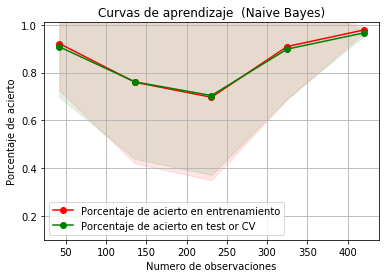

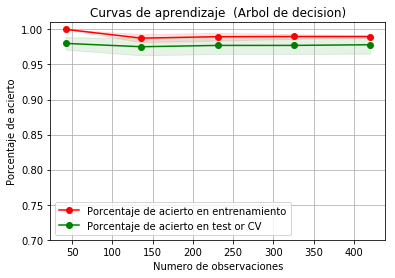

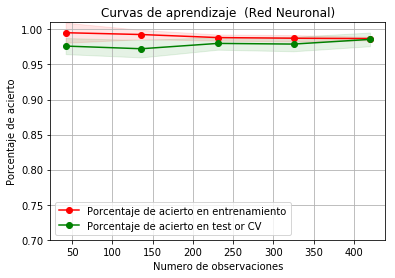

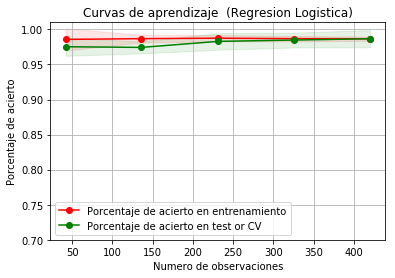

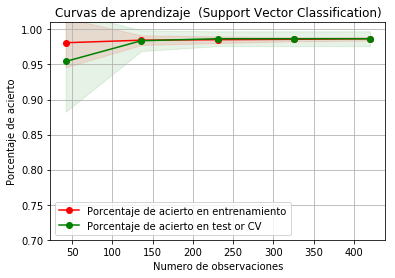

In [8]:
cv = ShuffleSplit(n_splits=10, test_size=0.2)

print(cv)

title = "Curvas de aprendizaje  (Naive Bayes)"
plot_learning_curve(gnb, title, X, y, (0.1, 1.01), cv=cv, n_jobs=10)

title = "Curvas de aprendizaje  (Arbol de decision)"
plot_learning_curve(dt, title, X, y, (0.7, 1.01), cv=cv, n_jobs=10)

title = "Curvas de aprendizaje  (Red Neuronal)"
plot_learning_curve(mlp, title, X, y, (0.7, 1.01), cv=cv, n_jobs=10)

title = "Curvas de aprendizaje  (Regresion Logistica)"
plot_learning_curve(lr, title, X, y, (0.7, 1.01), cv=cv, n_jobs=10)

title = "Curvas de aprendizaje  (Support Vector Classification)"
plot_learning_curve(svc, title, X, y, (0.7, 1.01), cv=cv, n_jobs=10)

plt.show()

### Curvas ROC para la Clase 0 - No vulnerable

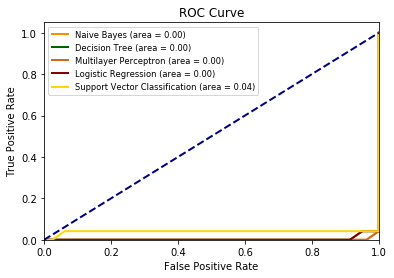

In [9]:
# Naive Bayes 
gnb_predict_probabilities = mlp.predict_proba(X_test)[:,0] 
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_predict_probabilities)
gnb_roc_auc = auc(gnb_fpr, gnb_tpr)

# Decision Tree
dt_predict_probabilities = dt.predict_proba(X_test)[:,0]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_predict_probabilities)
dt_roc_auc = auc(dt_fpr,dt_tpr)

# Multilayer Perceptron
mlp_predict_probabilities = mlp.predict_proba(X_test)[:,0]
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_predict_probabilities)
mlp_roc_auc = auc(mlp_fpr,mlp_tpr)

# Logistic Regression
lr_predict_probabilities = lr.predict_proba(X_test)[:,0]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_predict_probabilities)
lr_roc_auc = auc(lr_fpr, lr_tpr)

# Support Vector Classification 
svc_predict_probabilities = svc.predict_proba(X_test)[:,0]
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_predict_probabilities)
svc_roc_auc = auc(svc_fpr, svc_tpr)


plt.figure()
plt.plot(gnb_fpr, gnb_tpr, color='darkorange',
         lw=2, label='Naive Bayes (area = %0.2f)' % gnb_roc_auc)

plt.plot(dt_fpr, dt_tpr, color='darkgreen',
         lw=2, label='Decision Tree (area = %0.2f)' % dt_roc_auc)

plt.plot(mlp_fpr, mlp_tpr, color='chocolate',
         lw=2, label='Multilayer Perceptron (area = %0.2f)' % mlp_roc_auc)

plt.plot(lr_fpr,lr_tpr, color='darkred',
         lw=2, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)

plt.plot(svc_fpr, svc_tpr, color='gold',
         lw=2, label='Support Vector Classification (area = %0.2f)' % svc_roc_auc)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=2, fontsize='small')
plt.show()

### Curvas ROC para la Clase 1 - Vulnerable

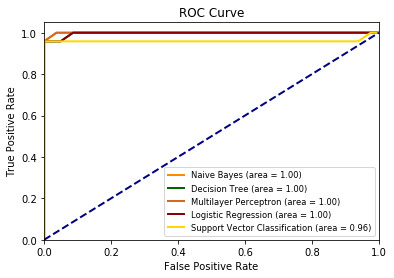

In [10]:
# Naive Bayes 
gnb_predict_probabilities = mlp.predict_proba(X_test)[:,1] 
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_predict_probabilities)
gnb_roc_auc = auc(gnb_fpr, gnb_tpr)

# Decision Tree
dt_predict_probabilities = dt.predict_proba(X_test)[:,1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_predict_probabilities)
dt_roc_auc = auc(dt_fpr,dt_tpr)

# Multilayer Perceptron
mlp_predict_probabilities = mlp.predict_proba(X_test)[:,1]
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_predict_probabilities)
mlp_roc_auc = auc(mlp_fpr,mlp_tpr)

# Logistic Regression
lr_predict_probabilities = lr.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_predict_probabilities)
lr_roc_auc = auc(lr_fpr, lr_tpr)

# Support Vector Classification 
svc_predict_probabilities = svc.predict_proba(X_test)[:,1]
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_predict_probabilities)
svc_roc_auc = auc(svc_fpr, svc_tpr)


plt.figure()
plt.plot(gnb_fpr, gnb_tpr, color='darkorange',
         lw=2, label='Naive Bayes (area = %0.2f)' % gnb_roc_auc)

plt.plot(dt_fpr, dt_tpr, color='darkgreen',
         lw=2, label='Decision Tree (area = %0.2f)' % dt_roc_auc)

plt.plot(mlp_fpr, mlp_tpr, color='chocolate',
         lw=2, label='Multilayer Perceptron (area = %0.2f)' % mlp_roc_auc)

plt.plot(lr_fpr,lr_tpr, color='darkred',
         lw=2, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)

plt.plot(svc_fpr, svc_tpr, color='gold',
         lw=2, label='Support Vector Classification (area = %0.2f)' % svc_roc_auc)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4, fontsize='small')
plt.show()

### Matriz de confusión

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()
    plt.show()

In [12]:
class_names=[0,1]

Confusion matrix, without normalization


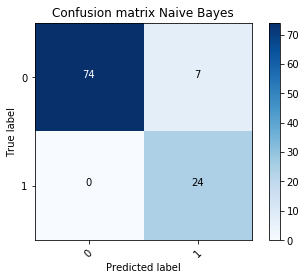

In [13]:
# Matriz de confusión del Naive Bayes 
gnb_matrix=confusion_matrix(y_test, y_predict_gnb, labels=class_names)
plot_confusion_matrix(gnb_matrix, classes=class_names, title='Confusion matrix Naive Bayes')

Confusion matrix, without normalization


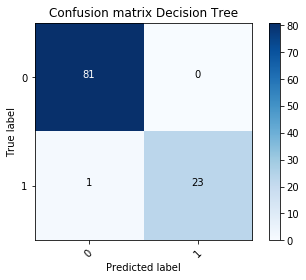

In [14]:
# Matriz de confusión del Decision Tree
dt_matrix=confusion_matrix(y_test, y_predict_dt, labels=class_names)
plot_confusion_matrix(dt_matrix, classes=class_names, title='Confusion matrix Decision Tree')

Confusion matrix, without normalization


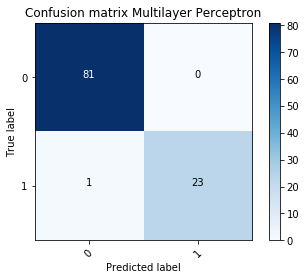

In [15]:
# Matriz de confusión del Multilayer Perceptron
mlp_matrix=confusion_matrix(y_test, y_predict_mlp, labels=class_names)
plot_confusion_matrix(mlp_matrix, classes=class_names, title='Confusion matrix Multilayer Perceptron')

Confusion matrix, without normalization


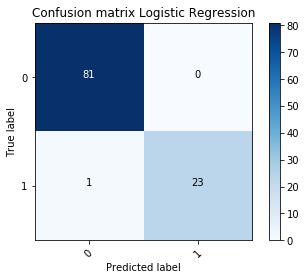

In [16]:
# Matriz de confusión del Logistic Regression
lr_matrix=confusion_matrix(y_test, y_predict_lr, labels=class_names)
plot_confusion_matrix(lr_matrix, classes=class_names, title='Confusion matrix Logistic Regression')

Confusion matrix, without normalization


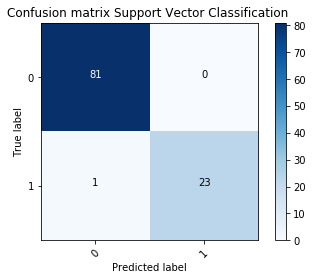

In [17]:
# Matriz de confusión del Support Vector Classification 
svc_matrix=confusion_matrix(y_test, y_predict_svc, labels=class_names)
plot_confusion_matrix(svc_matrix, classes=class_names, title='Confusion matrix Support Vector Classification ')